# ConvLSTM

## Pre-setup

#### Import the required libraries

In [1]:
# Import the required libraries.
import os
import math
import random
import numpy as np
import datetime as datetime
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
from batch_data_generator import DataGenerator

Import tensorflow and check for GPU support

In [3]:
# Print num of GPUs if available to use
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Set a seed to reproduce the results

In [4]:
seed_constant = 123
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Set data directories and other constants for the model

In [5]:
# Data paths are defined here
DATA_DIR = 'data'
VIDEO_PATH = os.path.join(DATA_DIR, 'videos')
ANNOTATION_PATH = os.path.join(DATA_DIR, 'annotations')
TRAINING_PATH = os.path.join(VIDEO_PATH, 'training')
TESTING_PATH = os.path.join(VIDEO_PATH, 'testing')
VALIDATION_PATH = os.path.join(VIDEO_PATH, 'validation')

In [6]:
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Set a minimum duration in seconds to extract sequence in multiples of
MIN_DURATION = 150

(DIMENSION_X, DIMENSION_Y, DIMENSION_C) = (224, 224, 3)

# Get the names of all classes/categories in our dataset.
CLASSES_LIST = os.listdir(TRAINING_PATH)

Define a easily readable class name mapping

In [7]:
class_mapping = {
'_cut___chop___slice_a_vegetable,_fruit,_or_meat_' : 'cut vegetables, herbs or meat',
'browse_through_clothing_items_on_rack___shelf___hanger' : 'browse through clothing items',
'clean___wipe_other_surface_or_object' : 'clean surface',
'dig_or_till_the_soil_with_a_hoe_or_other_tool' : 'till soil with a hoe',
'read_a_book___magazine___shopping_list_etc' : 'read a book',
'throw_away_trash___put_trash_in_trash_can' : 'throw away trash',
'wash_dishes___utensils___bakeware_etc' : 'wash utensils'}

## Read npy files in data generator

Get the file paths and corresponsing labels for the data generator (**Run everytime kernel is (re)started**)

In [8]:
def get_nparray_and_labels_in_partition(partition_path):
	nparrayfile_paths = []
	labels = {}
	for class_name in os.listdir(partition_path):
		if class_name not in CLASSES_LIST:
			print(f'{class_name} not found in class list!')
			continue
		for video_file_name in os.listdir(os.path.join(partition_path, class_name)):
			if not video_file_name.endswith('.npy'): continue
			nparrayfile_path = os.path.join(partition_path, class_name, video_file_name)
			nparrayfile_paths.append(nparrayfile_path)
			labels[nparrayfile_path] = CLASSES_LIST.index(class_name)
	return nparrayfile_paths, labels

Split the data into train, validation and test sets

In [9]:
nparray_partition = {}
nparray_labels = {}
nparray_partition['train'], nparray_labels['train'] = get_nparray_and_labels_in_partition(TRAINING_PATH)
nparray_partition['test'], nparray_labels['test'] = get_nparray_and_labels_in_partition(TESTING_PATH)
nparray_partition['validation'], nparray_labels['validation'] = get_nparray_and_labels_in_partition(VALIDATION_PATH)

Define parameters for data generator

In [10]:
train_data_generator_params = {
	'batch_size' : 5,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

validation_data_generator_params = {
	'batch_size' : 5,
	'sequence_length' : SEQUENCE_LENGTH,
	'n_classes' : len(CLASSES_LIST),
	'min_duration' : MIN_DURATION,
	'shuffle' : True
}

In [11]:
training_generator = DataGenerator(nparray_partition['train'], nparray_labels['train'], **train_data_generator_params)
validation_generator = DataGenerator(nparray_partition['validation'], nparray_labels['validation'], **validation_data_generator_params)

## Create model - ConvLSTM

Imports

In [12]:
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Function to create keras sequential model

In [13]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    model.add(Input(shape=(SEQUENCE_LENGTH, DIMENSION_X, DIMENSION_Y, DIMENSION_C)))
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    # model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
    #                      recurrent_dropout=0.2, return_sequences=True))
    # model.add(BatchNormalization())
    # model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Create model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 222, 222, 4)   1024      
                                                                 
 batch_normalization (BatchN  (None, 30, 222, 222, 4)  16        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 111, 111, 4)  0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 111, 111, 4)  0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 109, 109, 8)   3488      
                                                        

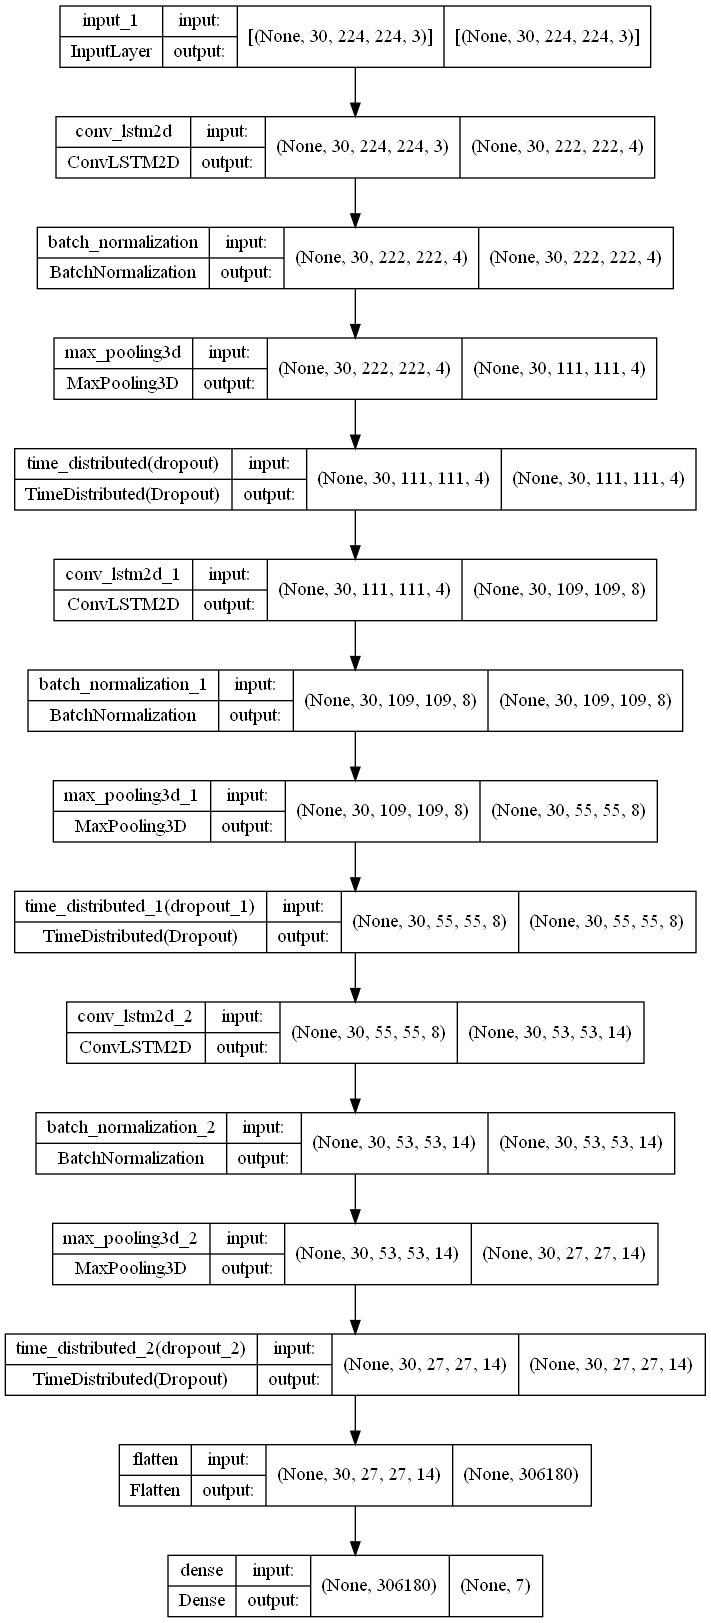

In [14]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Compile and train the model

In [15]:
%%time
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
optimizer = 'adam'
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ["accuracy"])

CPU times: total: 0 ns
Wall time: 5.11 ms


In [16]:
%%time
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = training_generator, 
    validation_data = validation_generator,
    use_multiprocessing=True,
    workers=6, 
    epochs = 20,
    callbacks = [early_stopping_callback])

Epoch 1/20
 57/197 [=======>......................] - ETA: 3:44 - loss: 98.2056 - accuracy: 0.3228

KeyboardInterrupt: 

Evaluate the model on test dataset

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(x = validation_generator, use_multiprocessing=True, workers=6)

### TO-DO:

- Explore different params to finetune model